In [1]:
import os

import numpy as np
import scipy.integrate as integrate
import scipy.interpolate as interp
import scipy.ndimage as ndi

import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt

from migdalcalc import migdalcalc as mc
from migdalcalc.migdal import ionization as ion

In [2]:
#use the to interpolate the power law tail of the SPS neutron beam
def interp_csv(file_name, skip_header=0):
    plot_data = np.genfromtxt(file_name, delimiter=',', skip_header=skip_header)
    x = list(zip(*plot_data))[0]
    y = list(zip(*plot_data))[1]
    
    return interp.interp1d(x, y, bounds_error=False, fill_value = 0, kind='quadratic')

In [3]:
#used to turn the luminosity distribution to a probability ditribution
def energy_distribution(Lumi):
    norm = integrate.quad(Lumi, 1, 100, limit=100,points=Lumi.x)[0]
    
    return lambda E: 1/(norm)*Lumi(E)

In [4]:
#This is to combine the spectra together
def dR_dDeltaE_combined(migdal, Lumi, Ei_min, Ei_max, flux_factor=1, method='elf-ibe'):
    A = migdal.A
    
    #do steps of 1 eV
    a_pts = np.arange(Ei_min, Ei_max, step = 1)
    b_pts = np.append(a_pts[1:], Ei_max)
    
    L = energy_distribution(Lumi)
        
    migdal_spectra = []
    

    for (a, b) in zip(a_pts, b_pts):
        flux = integrate.quad(L, a, b, limit=200)[0]
        mid_point = (a + b)/2
        spec = migdal.dR_dDeltaE_HS(mid_point, method, flux)
        migdal_spectra.append(spec)
    
    dE_max = (A/(A+1))*Ei_max
    dE_range = np.geomspace(1e-3, dE_max, 100)
    
    dR_dDeltaE_out = []
    
    for dE in dE_range:
        acc = 0
        for mig_spec in migdal_spectra:
            acc += flux_factor*mig_spec(dE)
        
        dR_dDeltaE_out.append(acc)
        
    return interp.interp1d(dE_range, dR_dDeltaE_out, bounds_error = False, fill_value=0)

In [5]:
Si_migdal = mc.migdalcalc(target="Si-28", nuclear_data_name="jeff33")

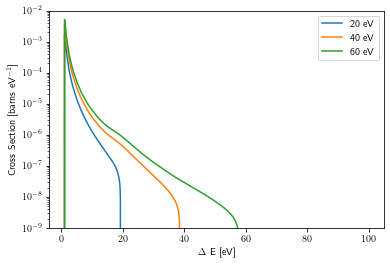

In [6]:
spec_20 = Si_migdal.dR_dDeltaE_HS(20, method='elf-ibe')
spec_40 = Si_migdal.dR_dDeltaE_HS(40, method='elf-ibe')
spec_60 = Si_migdal.dR_dDeltaE_HS(60, method='elf-ibe')

dE_range = np.geomspace(1, 100, 1000)

plt.plot(dE_range, spec_20(dE_range), label='20 eV')
plt.plot(dE_range, spec_40(dE_range), label='40 eV')
plt.plot(dE_range, spec_60(dE_range), label='60 eV')
plt.legend()
plt.xlabel(r'$\Delta$ E [eV]')
plt.ylabel(r'Cross Section [barns eV$^{-1}$]')

plt.yscale('log')
plt.ylim(1e-9, 1e-2)
plt.show()

In [7]:
Lumi20x20 = interp_csv('./input/oakridge/STS-20x20.csv')
Lumi100x100 = interp_csv('./input/oakridge/STS-100x100.csv')

In [8]:
thickness = 0.1 #1 mm in cm
density =  4.99e22 #per cubic cm
barns_to_cm2 = 1e-24
xsec_to_events_per_nuetron = density*thickness*barns_to_cm2

In [9]:
spec20x20 = dR_dDeltaE_combined(Si_migdal, Lumi20x20, 1, 100, flux_factor=xsec_to_events_per_nuetron, method='elf-ibe')
spec100x100 = dR_dDeltaE_combined(Si_migdal, Lumi100x100, 1, 100, flux_factor=xsec_to_events_per_nuetron, method='elf-ibe')

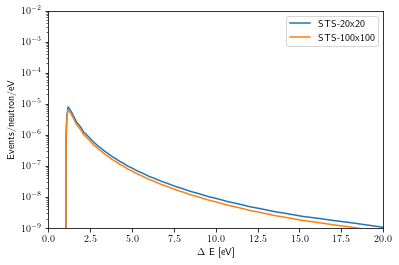

In [10]:
plt.plot(dE_range, spec20x20(dE_range), label="STS-20x20")
plt.plot(dE_range, spec100x100(dE_range), label="STS-100x100")
plt.legend()
plt.yscale('log')
plt.xlabel(r'$\Delta$ E [eV]')
plt.ylabel(r'Events/neutron/eV')
plt.xlim(0, 20)
plt.ylim(1e-9, 1e-2)
plt.show()

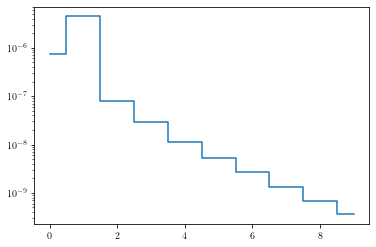

In [11]:
n20x20, r20x20 = ion.Si_electron_spectrum(spec20x20, 0, start_bin=0, number_of_bins=10)

plt.step(n20x20, r20x20, where='mid')
plt.yscale('log')
plt.show()